In [6]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from clickhouse_driver import Client
df = pd.read_csv("3_weeks.csv")


client = Client(host='',database="february2024",user="",password="",
client_name="python-driver from avisoiu")
client.execute("SET max_query_size = 10000000000")
def show_plots(method_name, show_stats=True):
    path = f"results/{method_name}"
    labels = pd.read_csv(f"{path}/labels.csv")

    df['label'] = labels['0']
    noise = df[df['label'] == -1].sort_values(by="total_hits")
    no_noise = df[df['label'] != -1]
    
    print(f"Noise: {noise.shape[0]}")

    one_subnet = []
    one_asn = []
    three_asn = []
    three_subnets = []
    one_country = []
    three_countries = []
    more_countries = []
    heavy_hitters = []
    more = []

    two_ips = []
    three_ips = []
    less_10_ips = []
    less_100_ips = []
    less_1000_ips = []
    more_ips = []

    unique_labels = labels['0'].unique()
    print(f"Clusters: {len(unique_labels)}")
    for label in unique_labels:
        if label == -1: continue 
        group = df[df['label'] == label]
        subnet_no = group['subnet'].nunique() 
        if subnet_no <= 1: 
            one_subnet.append(label)
        elif subnet_no <= 3:
            three_subnets.append(label)
        else:
            country_no = group['country'].nunique()
            if country_no == 1:
                one_country.append(label)
            elif country_no <= 3:
                three_countries.append(label)
            else:
                more.append(label)
        hits_per_day = group['total_hits'].sum()

        if hits_per_day > 30000:
            heavy_hitters.append(label)

        entries = group.shape[0]
        if entries == 2:
            two_ips.append(label)
        elif entries <= 3:
            three_ips.append(label)
        elif entries <= 10:
            less_10_ips.append(label)
        elif entries <= 100:
            less_100_ips.append(label)
        elif entries <= 1000:
            less_1000_ips.append(label)
        else: 
            more_ips.append(label)

    distributed_heavy_hitters = list(set(heavy_hitters) & set(more))
    print(f"One subnet: {len(one_subnet)}")
    print(f"Three subnets: {len(three_subnets)}")
    print(f"Heavy hitters: {len(heavy_hitters)}")
    print(f"One country: {len(one_country)}")
    print(f"<=3 countries: {len(three_countries)}")
    print(f"More than 3 countries and 3 subnets: {len(more)}")
    print(f"Distributed heavy hitters: {len(distributed_heavy_hitters)}")
    
    categories = ['one_subnet', 'three_subnets', 'one_country', 'three_countries', 'more_subnets']
    values = [len(one_subnet), len(three_subnets),  len(one_country), len(three_countries), len(more)]
    
    plt.bar(categories, values)
    plt.xlabel('Categories')
    plt.ylabel('Value')
    plt.title('Group Composition')
    plt.show()

    print(f"Clusters by number of IPs:")
    print(f"=2: {len(two_ips)}")
    print(f"= 3: {len(three_ips)}")
    print(f"<= 10: {len(less_10_ips)}")
    print(f"<= 100: {len(less_100_ips)}")
    print(f"<= 1000: {len(less_1000_ips)}")
    print(f">1000: {len(more_ips)}")

    categories_ips = ['2', '3', '<=10', '<=100', '<=1000', '>1000']
    values_ips = [len(two_ips), len(three_ips), len(less_10_ips), len(less_100_ips), len(less_1000_ips), len(more_ips)]

    plt.bar(categories_ips, values_ips)
    plt.xlabel('Group Size')
    plt.ylabel('Values')
    plt.title('Group Size Chart')
    plt.show()


    write_groups(distributed_heavy_hitters, f"analysis/{method_name}/distributed_heavy_hitters")
    write_groups(heavy_hitters, f"analysis/{method_name}/heavy_hitters")
    write_groups(more, f"analysis/{method_name}/geo_distributed")

    if show_stats == True:
        compute_stats(heavy_hitters, f"analysis/{method_name}", "heavy_hitters_stats")

def write_groups(groups, path):
    for group in groups:
        group_df = df[df['label'] == group]
        group_df.to_csv(f"{path}/group_{group}.csv")
    print(f"Groups written to {path}")

def compute_stats(groups, path, filename):
    stats_df = pd.DataFrame(columns=['group', 'distinct_hit_ips', 'overlaps', 'avg_overlap_times', 'avg_dest_ports'])
    stats_list = []
    for group in groups:
        group_df = df[df['label'] == group]
        ip_list = [math.floor(ip) for ip in group_df['src_ip']]
        result = client.execute("""
        WITH IpTraffic AS (
            SELECT SrcIP as src_ip,
                   DstIP as dst_ip,
                   DstPort as dst_port,
                   Timestamp as time,
                   any(Timestamp) OVER (PARTITION BY DstIP, DstPort, toDate(Timestamp) ORDER BY Timestamp ASC ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) as time_prev_hit,
                   any(SrcIP) OVER (PARTITION BY DstIP, DstPort, toDate(Timestamp) ORDER BY Timestamp ASC ROWS BETWEEN 1 PRECEDING AND 1 PRECEDING) as ip_prev_hit,
                   if(toDate(time_prev_hit) = '1970-01-01', 11000, age('s', time_prev_hit, time)) as time_diff -- 10800s = 3hrs
            FROM tcppackets
            WHERE SrcIP IN %(ips)s
        ), OverlapCounter AS (
            SELECT dst_ip, dst_port, toDate(time) as date, COUNT(DISTINCT src_ip) as overlap_count
            FROM IpTraffic
            WHERE time_diff < 10800 AND ip_prev_hit != src_ip
            GROUP BY dst_ip, dst_port, date
            HAVING COUNT(DISTINCT src_ip) > 1)
        SELECT a.distinct_dest_ips as distinct_dest_ips,
               if(isNaN(b.overlaps), 0, b.overlaps) as overlaps,
               if(isNaN(b.avg_overlap), 0, b.avg_overlap) as avg_overlap
        FROM (SELECT COUNT(DISTINCT dst_ip) AS distinct_dest_ips from IpTraffic) as a, (SELECT COUNT(DISTINCT dst_ip)/COUNT(DISTINCT date) as overlaps, avg(overlap_count) as avg_overlap FROM OverlapCounter) as b
        """,
            { 'ips': tuple(ip_list)});
        distinct_dst_ips = result[0][0]
        overlaps = result[0][1]
        avg_overlap_no = result[0][2]
        avg_dest_ports = group_df['distinct_dest_ports'].mean()
        stats_list.append([group, distinct_dst_ips, overlaps, avg_overlap_no, avg_dest_ports])
        new_row = {'group': group, 'distinct_hit_ips': distinct_dst_ips, 'overlaps': overlaps, 'avg_overlap_times': avg_overlap_no, 'avg_dest_ports': avg_dest_ports}
        print(new_row)

    stats_df = pd.DataFrame(stats_list,columns=['group', 'distinct_hit_ips', 'overlaps', 'avg_overlap_times', 'avg_dest_ports'])
    stats_df.sort_values(by=['overlaps', 'distinct_hit_ips'], ascending=[True, False]).to_csv(f"{path}/{filename}.csv")
    

Noise: 453081
Clusters: 10271
One subnet: 501
Three subnets: 353
Heavy hitters: 263
More than 3 countries and 3 subnets: 480


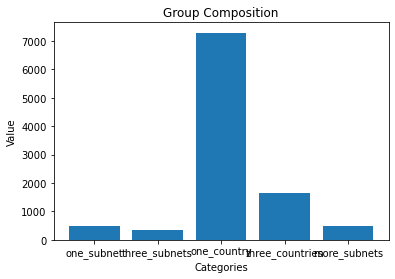

Clusters by number of IPs:
=2: 0
= 3: 0
<= 10: 318
<= 100: 9295
<= 1000: 621
>1000: 36


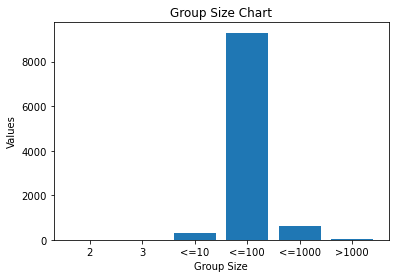

Groups written to analysis/hdb_v1/heavy_hitters
Groups written to analysis/hdb_v1/geo_distributed


In [2]:
show_plots("hdb_v1")

Noise: 552927
Clusters: 8923
One subnet: 334
Three subnets: 194
Heavy hitters: 210
More than 3 countries and 3 subnets: 554


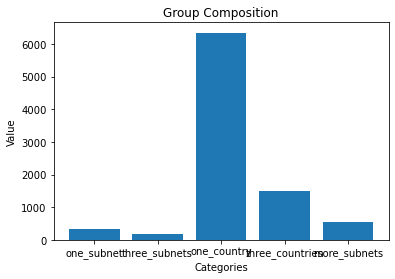

Clusters by number of IPs:
=2: 0
= 3: 0
<= 10: 318
<= 100: 8102
<= 1000: 483
>1000: 19


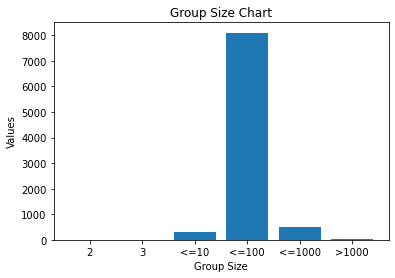

Groups written to analysis/hdb_v2/heavy_hitters
Groups written to analysis/hdb_v2/geo_distributed


In [3]:
show_plots("hdb_v2")

Noise: 452873
Clusters: 10555
One subnet: 490
Three subnets: 359
Heavy hitters: 275
More than 3 countries and 3 subnets: 484


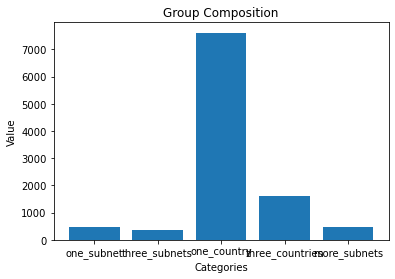

Clusters by number of IPs:
=2: 0
= 3: 0
<= 10: 411
<= 100: 9531
<= 1000: 578
>1000: 34


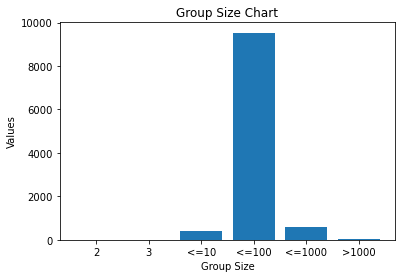

Groups written to analysis/hdb_v3/heavy_hitters
Groups written to analysis/hdb_v3/geo_distributed


In [4]:
show_plots("hdb_v3")

Noise: 354227
Clusters: 67151
One subnet: 3051
Three subnets: 10846
Heavy hitters: 676
More than 3 countries and 3 subnets: 701


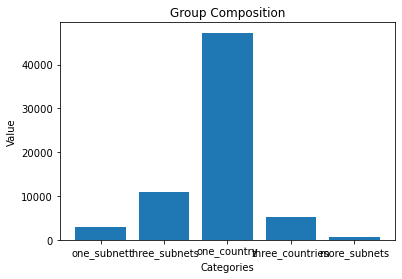

Clusters by number of IPs:
=2: 0
= 3: 6269
<= 10: 47804
<= 100: 12937
<= 1000: 138
>1000: 2


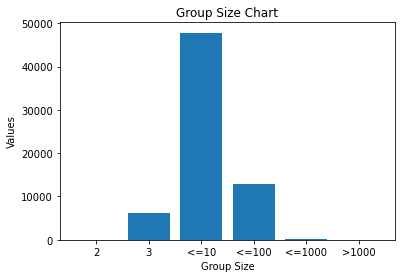

Groups written to analysis/hdb_v4/heavy_hitters
Groups written to analysis/hdb_v4/geo_distributed


In [5]:
show_plots("hdb_v4")

Noise: 430318
Clusters: 57784
One subnet: 1912
Three subnets: 9298
Heavy hitters: 557
More than 3 countries and 3 subnets: 1023


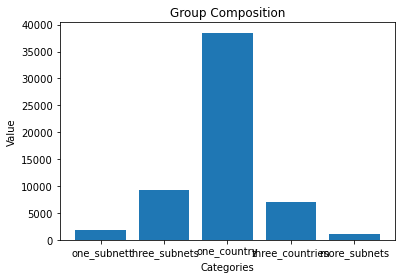

Clusters by number of IPs:
=2: 0
= 3: 6102
<= 10: 40870
<= 100: 10655
<= 1000: 155
>1000: 1


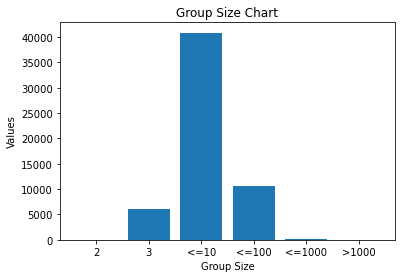

Groups written to analysis/hdb_v5/heavy_hitters
Groups written to analysis/hdb_v5/geo_distributed


In [6]:
show_plots("hdb_v5")

Noise: 278683
Clusters: 125893
One subnet: 7417
Three subnets: 52502
Heavy hitters: 1136
More than 3 countries and 3 subnets: 653


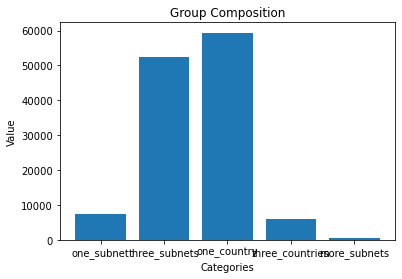

Clusters by number of IPs:
=2: 17259
= 3: 30961
<= 10: 70757
<= 100: 6878
<= 1000: 37
>1000: 0


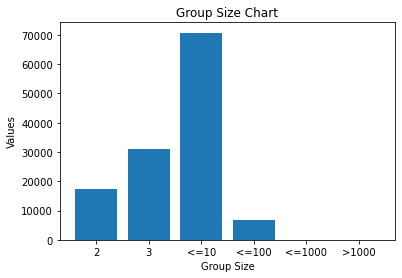

Groups written to analysis/hdb_v6/heavy_hitters
Groups written to analysis/hdb_v6/geo_distributed


In [7]:
show_plots("hdb_v6")

Noise: 345859
Clusters: 115017
One subnet: 5107
Three subnets: 50678
Heavy hitters: 1005
More than 3 countries and 3 subnets: 1064


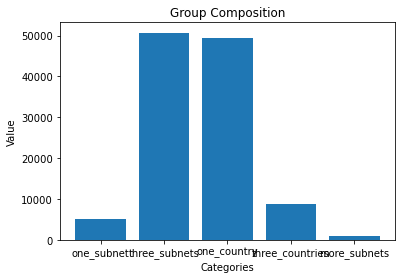

Clusters by number of IPs:
=2: 18279
= 3: 29496
<= 10: 61242
<= 100: 5960
<= 1000: 39
>1000: 0


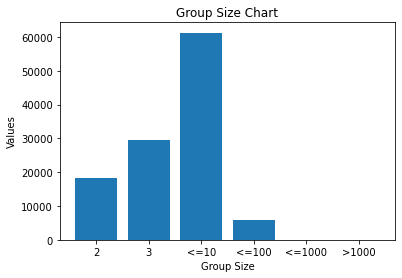

Groups written to analysis/hdb_v7/heavy_hitters
Groups written to analysis/hdb_v7/geo_distributed


In [8]:
show_plots("hdb_v7")

Noise: 292188
Clusters: 123939
One subnet: 7280
Three subnets: 52237
Heavy hitters: 1119
More than 3 countries and 3 subnets: 748


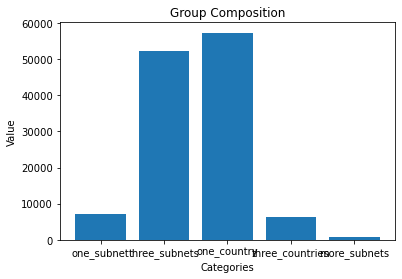

Clusters by number of IPs:
=2: 17468
= 3: 30803
<= 10: 69061
<= 100: 6562
<= 1000: 44
>1000: 0


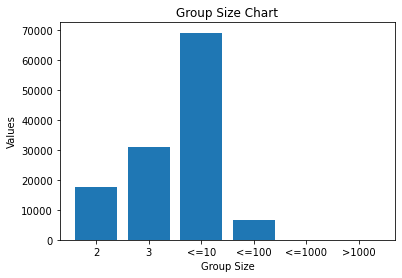

Groups written to analysis/hdb_v8/heavy_hitters
Groups written to analysis/hdb_v8/geo_distributed


In [10]:
show_plots("hdb_v8")

Noise: 291960
Clusters: 123969
One subnet: 7216
Three subnets: 52317
Heavy hitters: 1100
More than 3 countries and 3 subnets: 745


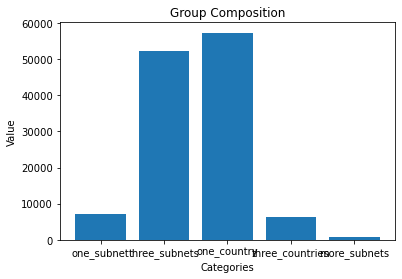

Clusters by number of IPs:
=2: 17536
= 3: 30669
<= 10: 69122
<= 100: 6601
<= 1000: 40
>1000: 0


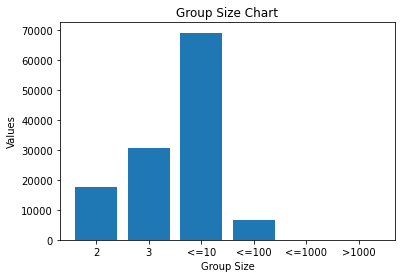

Groups written to analysis/hdb_v9/heavy_hitters
Groups written to analysis/hdb_v9/geo_distributed


In [16]:
show_plots("hdb_v9")

Noise: 291960
Clusters: 120156
One subnet: 3403
Three subnets: 52317
Heavy hitters: 934
More than 3 countries and 3 subnets: 745


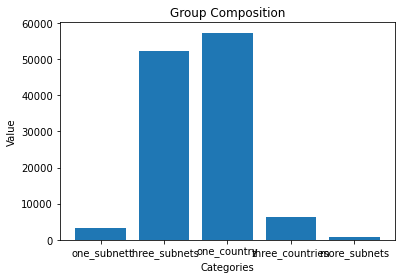

Clusters by number of IPs:
=2: 16804
= 3: 29592
<= 10: 67014
<= 100: 6646
<= 1000: 99
>1000: 0


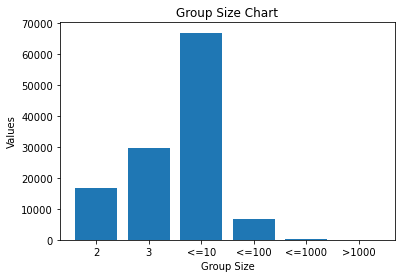

Groups written to analysis/hdb_v9_post/heavy_hitters
Groups written to analysis/hdb_v9_post/geo_distributed


In [3]:
show_plots("hdb_v9_post")

Noise: 462697
Clusters: 63092
One subnet: 3096
Three subnets: 10042
Heavy hitters: 677
More than 3 countries and 3 subnets: 613


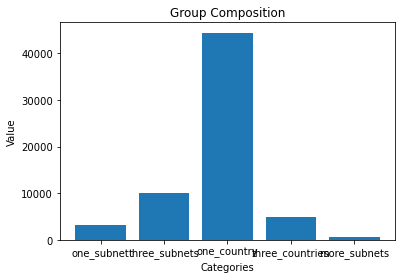

Clusters by number of IPs:
=2: 2121
= 3: 4317
<= 10: 46473
<= 100: 10180
<= 1000: 0
>1000: 0


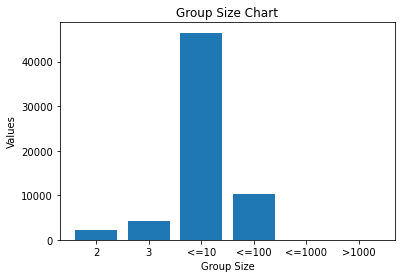

Groups written to analysis/optics_v1/heavy_hitters
Groups written to analysis/optics_v1/geo_distributed


In [4]:
show_plots("optics_v1")

Noise: 316442
Clusters: 115249
One subnet: 6378
Three subnets: 48882
Heavy hitters: 1067
More than 3 countries and 3 subnets: 884


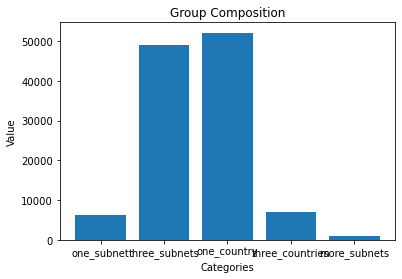

Clusters by number of IPs:
=2: 16657
= 3: 28815
<= 10: 62951
<= 100: 6740
<= 1000: 84
>1000: 1


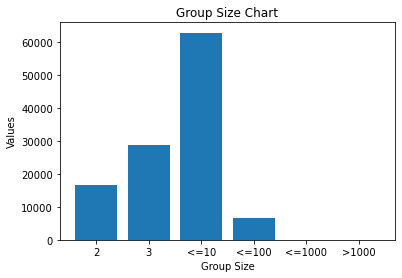

Groups written to analysis/hdb_v10/heavy_hitters
Groups written to analysis/hdb_v10/geo_distributed


In [5]:
show_plots("hdb_v10")

Noise: 316442
Clusters: 112082
One subnet: 3211
Three subnets: 48882
Heavy hitters: 918
More than 3 countries and 3 subnets: 884
Distributed heavy hitters: 50


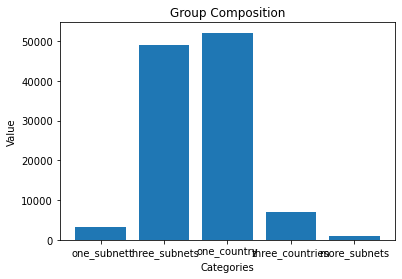

Clusters by number of IPs:
=2: 16076
= 3: 27910
<= 10: 61255
<= 100: 6705
<= 1000: 134
>1000: 1


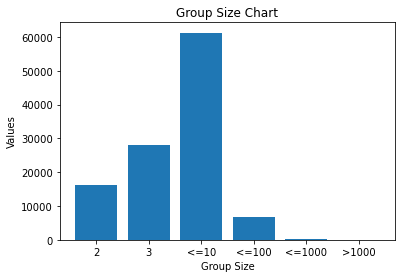

Groups written to analysis/hdb_v10_post/distributed_heavy_hitters
Groups written to analysis/hdb_v10_post/heavy_hitters
Groups written to analysis/hdb_v10_post/geo_distributed
{'group': 96, 'distinct_hit_ips': 65513, 'overlaps': 62288, 'avg_overlap_times': 3.1757886690703483, 'avg_dest_ports': 4.94949494949495}
{'group': 9988, 'distinct_hit_ips': 20520, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 26704, 'distinct_hit_ips': 60690, 'overlaps': 10496, 'avg_overlap_times': 2.1326219512195124, 'avg_dest_ports': 1.375}
{'group': 592, 'distinct_hit_ips': 62241, 'overlaps': 39466, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.0}
{'group': 36, 'distinct_hit_ips': 114748, 'overlaps': 60434, 'avg_overlap_times': 2.1633021147036438, 'avg_dest_ports': 347.95}
{'group': 577, 'distinct_hit_ips': 62234, 'overlaps': 4733, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.3125}
{'group': 268, 'distinct_hit_ips': 62479, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 

In [3]:
show_plots("hdb_v10_post")

Noise: 298708
Clusters: 43727
One subnet: 2078
Three subnets: 29869
Heavy hitters: 451
More than 3 countries and 3 subnets: 169
Distributed heavy hitters: 12


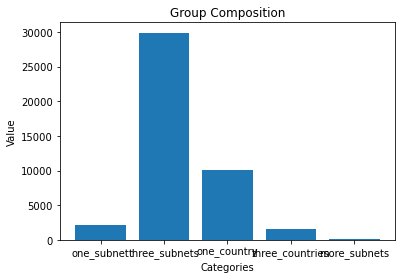

Clusters by number of IPs:
=2: 23267
= 3: 7207
<= 10: 9273
<= 100: 3420
<= 1000: 503
>1000: 56


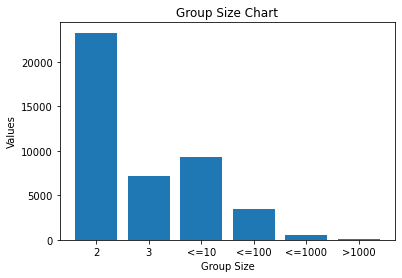

Groups written to analysis/db_v4_post/distributed_heavy_hitters
Groups written to analysis/db_v4_post/heavy_hitters
Groups written to analysis/db_v4_post/geo_distributed


In [8]:
show_plots("db_v4_post")

Noise: 244753
Clusters: 39461
One subnet: 1867
Three subnets: 26769
Heavy hitters: 543
More than 3 countries and 3 subnets: 312
Distributed heavy hitters: 15


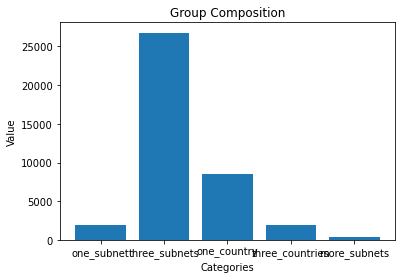

Clusters by number of IPs:
=2: 20598
= 3: 6630
<= 10: 8446
<= 100: 3243
<= 1000: 493
>1000: 50


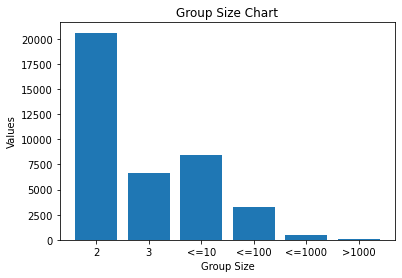

Groups written to analysis/db_v5_post/distributed_heavy_hitters
Groups written to analysis/db_v5_post/heavy_hitters
Groups written to analysis/db_v5_post/geo_distributed


In [9]:
show_plots("db_v5_post")

Noise: 316940
Clusters: 112110
One subnet: 3260
Three subnets: 48789
Heavy hitters: 918
More than 3 countries and 3 subnets: 869
Distributed heavy hitters: 48


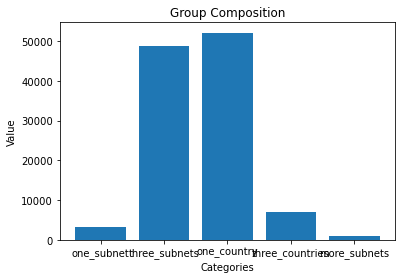

Clusters by number of IPs:
=2: 15898
= 3: 28074
<= 10: 61370
<= 100: 6632
<= 1000: 134
>1000: 1


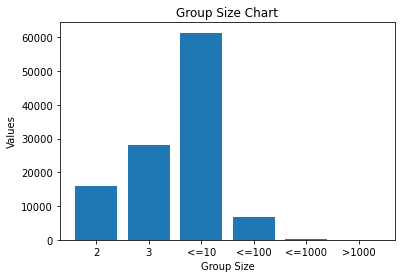

Groups written to analysis/hdb_v11_post/distributed_heavy_hitters
Groups written to analysis/hdb_v11_post/heavy_hitters
Groups written to analysis/hdb_v11_post/geo_distributed
{'group': 10326, 'distinct_hit_ips': 20520, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 26868, 'distinct_hit_ips': 60690, 'overlaps': 10469, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.375}
{'group': 593, 'distinct_hit_ips': 62241, 'overlaps': 39364, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.0}
{'group': 22921, 'distinct_hit_ips': 22748, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 30.0}
{'group': 559, 'distinct_hit_ips': 62233, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0833333333333333}
{'group': 1743, 'distinct_hit_ips': 79369, 'overlaps': 62226, 'avg_overlap_times': 2.0, 'avg_dest_ports': 22.174715909090907}
{'group': 60896, 'distinct_hit_ips': 647, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 13.625}
{'group': 266, 'distinct_hi

In [3]:
show_plots("hdb_v11_post")

Noise: 316265
Clusters: 112918
One subnet: 3273
Three subnets: 49314
Heavy hitters: 1141
More than 3 countries and 3 subnets: 867
Distributed heavy hitters: 30


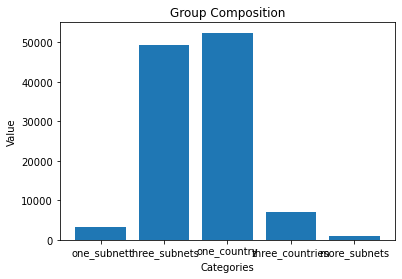

Clusters by number of IPs:
=2: 16144
= 3: 28220
<= 10: 61760
<= 100: 6661
<= 1000: 132
>1000: 0


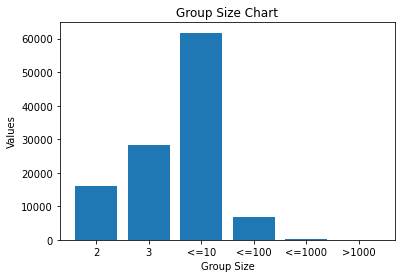

Groups written to analysis/hdb_v12_post/distributed_heavy_hitters
Groups written to analysis/hdb_v12_post/heavy_hitters
Groups written to analysis/hdb_v12_post/geo_distributed
{'group': 17068, 'distinct_hit_ips': 20520, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 209, 'distinct_hit_ips': 62239, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 91489, 'distinct_hit_ips': 48421, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 61160, 'distinct_hit_ips': 647, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 13.625}
{'group': 2634, 'distinct_hit_ips': 62846, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 1.0}
{'group': 3992, 'distinct_hit_ips': 5120, 'overlaps': 0, 'avg_overlap_times': nan, 'avg_dest_ports': 55.0}
{'group': 3181, 'distinct_hit_ips': 61970, 'overlaps': 61970, 'avg_overlap_times': 5.101490997437348, 'avg_dest_ports': 2.8333333333333335}
{'group': 499, 'distinct_hit_ips': 6222

In [4]:
show_plots("hdb_v12_post")

Noise: 316442
Clusters: 115249
One subnet: 6378
Three subnets: 48882
Heavy hitters: 1194
One country: 52066
<=3 countries: 7038
More than 3 countries and 3 subnets: 884
Distributed heavy hitters: 52


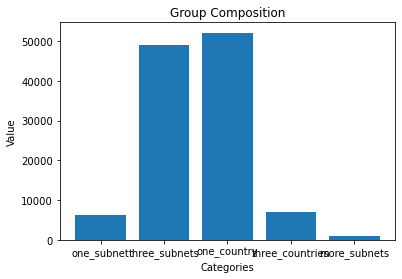

Clusters by number of IPs:
=2: 16657
= 3: 28815
<= 10: 62951
<= 100: 6740
<= 1000: 84
>1000: 1


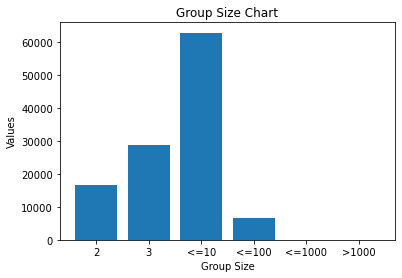

Groups written to analysis/hdb_fs1/distributed_heavy_hitters
Groups written to analysis/hdb_fs1/heavy_hitters
Groups written to analysis/hdb_fs1/geo_distributed
{'group': 96, 'distinct_hit_ips': 65513, 'overlaps': 1041.4444444444443, 'avg_overlap_times': 2.132625210785251, 'avg_dest_ports': 4.94949494949495}
{'group': 9988, 'distinct_hit_ips': 20520, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 26704, 'distinct_hit_ips': 60690, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.375}
{'group': 592, 'distinct_hit_ips': 62241, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 36, 'distinct_hit_ips': 114748, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 347.95}
{'group': 577, 'distinct_hit_ips': 62234, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.3125}
{'group': 21651, 'distinct_hit_ips': 12254, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 268, 'distinct_hit_

In [7]:
show_plots("hdb_fs1")

Noise: 316265
Clusters: 116333
One subnet: 6688
Three subnets: 49314
Heavy hitters: 1444
One country: 52384
<=3 countries: 7079
More than 3 countries and 3 subnets: 867
Distributed heavy hitters: 32


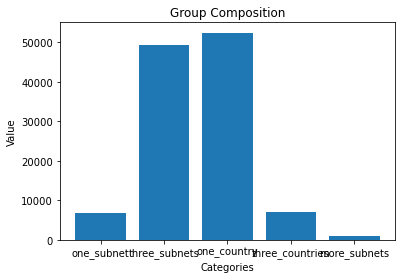

Clusters by number of IPs:
=2: 16758
= 3: 29203
<= 10: 63610
<= 100: 6686
<= 1000: 75
>1000: 0


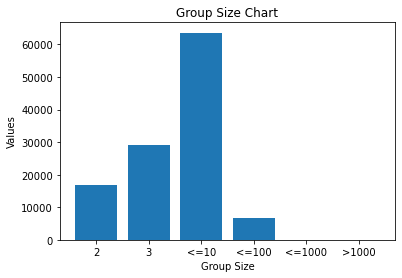

Groups written to analysis/hdb_fs2/distributed_heavy_hitters
Groups written to analysis/hdb_fs2/heavy_hitters
Groups written to analysis/hdb_fs2/geo_distributed
{'group': 30736, 'distinct_hit_ips': 63462, 'overlaps': 6.5, 'avg_overlap_times': 2.0, 'avg_dest_ports': 14.507769423558898}
{'group': 17068, 'distinct_hit_ips': 20520, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 98763, 'distinct_hit_ips': 38337, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 82250, 'distinct_hit_ips': 38301, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 209, 'distinct_hit_ips': 62239, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 91489, 'distinct_hit_ips': 48421, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 61160, 'distinct_hit_ips': 647, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 13.625}
{'group': 2634, 'distinct_hit_ips': 62846, 'overlaps': 

In [8]:
show_plots("hdb_fs2")

Noise: 493000
Clusters: 10398
One subnet: 586
Three subnets: 362
Heavy hitters: 282
One country: 7281
<=3 countries: 1642
More than 3 countries and 3 subnets: 526
Distributed heavy hitters: 39


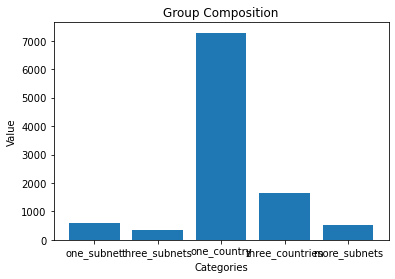

Clusters by number of IPs:
=2: 0
= 3: 0
<= 10: 315
<= 100: 9471
<= 1000: 591
>1000: 20


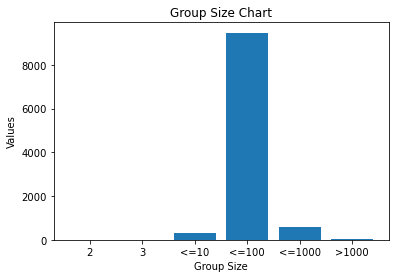

Groups written to analysis/hdb_fs1_10pts/distributed_heavy_hitters
Groups written to analysis/hdb_fs1_10pts/heavy_hitters
Groups written to analysis/hdb_fs1_10pts/geo_distributed
{'group': 286, 'distinct_hit_ips': 62754, 'overlaps': 10445.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.0246913580246915}
{'group': 3643, 'distinct_hit_ips': 3020, 'overlaps': 5.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 11.031470588235296}
{'group': 32, 'distinct_hit_ips': 16109, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 52.54545454545455}
{'group': 42, 'distinct_hit_ips': 61970, 'overlaps': 30985.0, 'avg_overlap_times': 6.623087826907167, 'avg_dest_ports': 2.736842105263158}
{'group': 84, 'distinct_hit_ips': 64022, 'overlaps': 12439.6, 'avg_overlap_times': 2.9678490383210963, 'avg_dest_ports': 2.0285714285714285}
{'group': 285, 'distinct_hit_ips': 63453, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 14.066666666666666}
{'group': 6686, 'distinct_hit_ips': 194, 'overl

In [9]:
show_plots("hdb_fs1_10pts")

Noise: 493702
Clusters: 10440
One subnet: 593
Three subnets: 365
Heavy hitters: 371
One country: 7311
<=3 countries: 1662
More than 3 countries and 3 subnets: 508
Distributed heavy hitters: 43


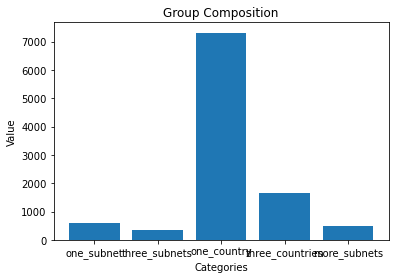

Clusters by number of IPs:
=2: 0
= 3: 0
<= 10: 300
<= 100: 9531
<= 1000: 590
>1000: 18


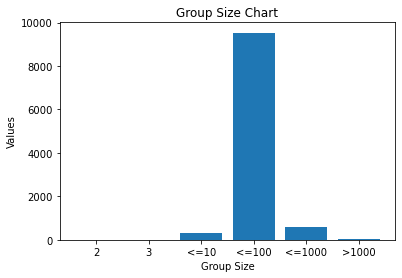

Groups written to analysis/hdb_fs2_10pts/distributed_heavy_hitters
Groups written to analysis/hdb_fs2_10pts/heavy_hitters
Groups written to analysis/hdb_fs2_10pts/geo_distributed
{'group': 4632, 'distinct_hit_ips': 62595, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.375}
{'group': 8434, 'distinct_hit_ips': 38344, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.1304347826086956}
{'group': 7291, 'distinct_hit_ips': 51559, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.1428571428571428}
{'group': 1281, 'distinct_hit_ips': 62242, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 6432, 'distinct_hit_ips': 38342, 'overlaps': 1.0, 'avg_overlap_times': 3.0, 'avg_dest_ports': 1.0}
{'group': 3616, 'distinct_hit_ips': 3003, 'overlaps': 5.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 11.021386554621849}
{'group': 242, 'distinct_hit_ips': 60395, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 36.4375}
{'group':

In [10]:
show_plots("hdb_fs2_10pts")

Noise: 362851
Clusters: 47770
One subnet: 3000
Three subnets: 32407
Heavy hitters: 489
One country: 11161
<=3 countries: 1128
More than 3 countries and 3 subnets: 73
Distributed heavy hitters: 6


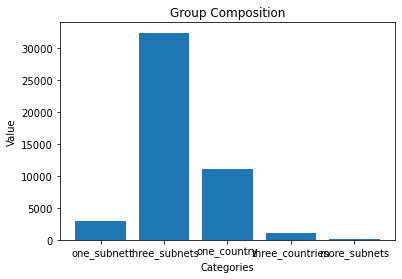

Clusters by number of IPs:
=2: 25711
= 3: 7960
<= 10: 9942
<= 100: 3560
<= 1000: 537
>1000: 59


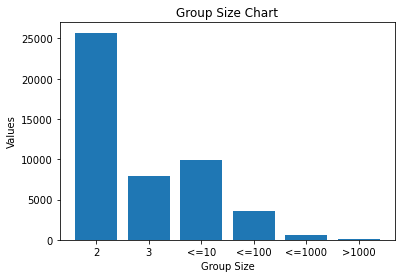

Groups written to analysis/db_fs1_eps01/distributed_heavy_hitters
Groups written to analysis/db_fs1_eps01/heavy_hitters
Groups written to analysis/db_fs1_eps01/geo_distributed
{'group': 50, 'distinct_hit_ips': 1303, 'overlaps': 2.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.0}
{'group': 1898, 'distinct_hit_ips': 2048, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 55.0}
{'group': 1907, 'distinct_hit_ips': 60514, 'overlaps': 5351.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 3.0}
{'group': 2067, 'distinct_hit_ips': 63453, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 14.066666666666666}
{'group': 2135, 'distinct_hit_ips': 52487, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 24.58461538461539}
{'group': 2514, 'distinct_hit_ips': 49737, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 2516, 'distinct_hit_ips': 49534, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0}
{'group': 2556, 'distinct_hit_ip

In [11]:
show_plots("db_fs1_eps01")

Noise: 360209
Clusters: 48082
One subnet: 3022
Three subnets: 32602
Heavy hitters: 823
One country: 11232
<=3 countries: 1148
More than 3 countries and 3 subnets: 77
Distributed heavy hitters: 17


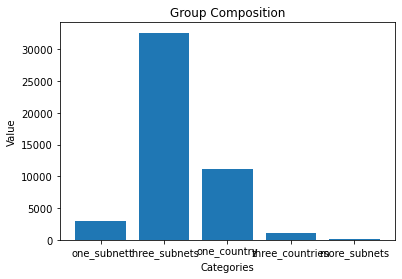

Clusters by number of IPs:
=2: 25887
= 3: 7999
<= 10: 10007
<= 100: 3590
<= 1000: 539
>1000: 59


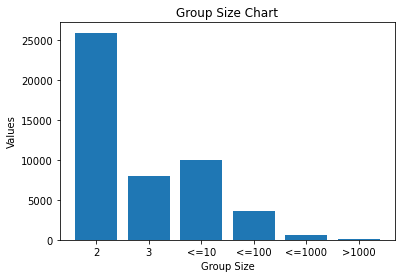

Groups written to analysis/db_fs2_eps01/distributed_heavy_hitters
Groups written to analysis/db_fs2_eps01/heavy_hitters
Groups written to analysis/db_fs2_eps01/geo_distributed
{'group': 50, 'distinct_hit_ips': 20768, 'overlaps': 2.0, 'avg_overlap_times': 2.0, 'avg_dest_ports': 1.0}
{'group': 105, 'distinct_hit_ips': 38751, 'overlaps': 1.1818181818181819, 'avg_overlap_times': 3.076923076923077, 'avg_dest_ports': 1.0978494623655914}
{'group': 121, 'distinct_hit_ips': 48428, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 1.0740740740740742}
{'group': 569, 'distinct_hit_ips': 38342, 'overlaps': 1.0, 'avg_overlap_times': 3.0, 'avg_dest_ports': 1.0}
{'group': 1873, 'distinct_hit_ips': 581, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 14.666666666666666}
{'group': 1905, 'distinct_hit_ips': 2048, 'overlaps': 0.0, 'avg_overlap_times': 0.0, 'avg_dest_ports': 55.0}
{'group': 1914, 'distinct_hit_ips': 60514, 'overlaps': 5351.0, 'avg_overlap_times': 2.0, 'avg_dest_port

In [12]:
show_plots("db_fs2_eps01")